In [1]:
import time
import torch
import warnings
import numpy as np
import matplotlib.pyplot as plt

from pina import Condition, LabelTensor, Trainer
from pina.solver import PINN
from pina.operator import grad
from pina.equation import Equation, FixedValue
from pina.model import FeedForward
from pina.callback import MetricTracker
from pina.domain import CartesianDomain
from pina.problem import SpatialProblem, TimeDependentProblem

In [2]:
# Definición del problema de advección 1D
class Advection(TimeDependentProblem, SpatialProblem):
    output_variables = ["u"]
    spatial_domain = CartesianDomain({"x": [0, 1]})
    temporal_domain = CartesianDomain({"t": [0, 1]})
    domains = {
        "g1": CartesianDomain({"x": 1, "t": [0, 1]}),
        "g2": CartesianDomain({"x": 0, "t": [0, 1]}),
        "initial": CartesianDomain({"x": [0, 1], "t": 0}),
        "D": CartesianDomain({"x": [0, 1], "t": [0, 1]}),
    }

    def __init__(self):
        super().__init__()
        self.c = torch.nn.Parameter(torch.rand(1))
        self.amplitudes = torch.nn.ParameterList([torch.nn.Parameter(torch.rand(1) * 0.5) for _ in range(3)])

    # Definición del PDE (advección)
    def advection_eq(self, input_, output_):

        # Ecuación de advección: u_t + c * u_x = 0
        
        u_t = grad(output_, input_, components=["u"], d=["t"])
        u_x = grad(output_, input_, components=["u"], d=["x"])
        return u_t + self.c * u_x

    # Condición inicial
    def initial_condition(self, input_, output_):

        # Condición inicial u(x, 0) = sum_k a_k * sin(2*pi*k*x)
        
        x = input_.extract(["x"])
        u_0 = torch.zeros_like(x)
        for k in range(1, 4):
            u_0 += self.amplitudes[k - 1] * torch.sin(2 * torch.pi * k * x)
        return output_.extract(["u"]) - u_0

    # Solución analítica exacta
    def solution(self, pts):
        x = pts.extract(["x"])
        t = pts.extract(["t"])
        f = torch.zeros_like(x)
        for k in range(1, 4):
            shifted_x = (x - self.c * t) % 1.0
            f += self.amplitudes[k - 1] * torch.sin(2 * torch.pi * k * shifted_x)
        return LabelTensor(f, self.output_variables)

    # Definimos "conditions" como propiedad
    @property
    def conditions(self):
        return {
            "g1": Condition(domain="g1", equation=FixedValue(0.0)),
            "g2": Condition(domain="g2", equation=FixedValue(0.0)),
            "initial": Condition(domain="initial", equation=Equation(self.initial_condition)),
            "D": Condition(domain="D", equation=Equation(self.advection_eq)),
        }


In [3]:
class HardMLP(torch.nn.Module):
    def __init__(self, input_dim, output_dim, amplitudes):
        super().__init__()
        self.amplitudes = amplitudes

        self.layers = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 64),
            torch.nn.Tanh(),
            torch.nn.Linear(64, 64),
            torch.nn.Tanh(),
            torch.nn.Linear(64, output_dim),
        )

    def u0(self, x):
        
        # Condición inicial u0(x), igual a la de Adv.initial_condition
        
        u0 = torch.zeros_like(x)
        for k in range(1, 4):
            u0 += self.amplitudes[k - 1] * torch.sin(2 * torch.pi * k * x)
        return u0

    def forward(self, pts):
        x = pts.extract(["x"])
        t = pts.extract(["t"])

        hard = x * (1 - x)

        # calculamos u0(x)
        u0 = self.u0(x)

        # salida de la red
        nn = self.layers(pts)

        # imponemos la restricción dura
        u_pinn = u0 + t * hard * nn
        return u_pinn

In [4]:
def FDM(amplitudes, c, dt):
    # Parámetros
    L = 1.0                                       # longitud del dominio
    nx = 300                                      # número de puntos espaciales
    dx = L / (nx - 1)
    c = c[0].tolist()                             # velocidad de advección
    nt = 300                                      # número de pasos de tiempo
    
    # Número de Courant
    sigma = c * dt / dx
    print(f"Número de Courant (CFL) = {sigma:.2f}")
    
    # Malla espacial
    x = np.linspace(0, L, nx)
    
    # Condición inicial:
    u_0 = np.zeros_like(x)
    for k in range(1, 4):
        u_0 += amplitudes[k - 1].tolist() * np.sin(2 * np.pi * k * x)
    
    # Inicialización
    u = u_0.copy()
    
    # Evolución temporal
    for n in range(nt):
        u_new = u.copy()
        # esquema FTBS para c > 0
        for i in range(1, nx):
            u_new[i] = u[i] - sigma * (u[i] - u[i-1])
        u = u_new
        # condición periódica (opcional)
        u[0] = u[-1]
    return x, u

In [5]:
# Definimos el problema
problem = Advection()

# Generamos los datos
problem.discretise_domain(1000, "random", domains="all")

# Definimos el modelo
model = HardMLP(
    input_dim=2,  # x, t
    output_dim=1,
    amplitudes=problem.amplitudes
    )

# Definimos la solución
solver = PINN(problem=problem, model=model)

In [6]:
print("Input vars:", problem.input_variables)
print("Output vars:", problem.output_variables)
print("Model input dim:", len(problem.input_variables))
print("Model output dim:", len(problem.output_variables))

Input vars: ['x', 't']
Output vars: ['u']
Model input dim: 2
Model output dim: 1


In [7]:
# create trainer and train
trainer = Trainer(
    solver=solver,
    max_epochs=121,
    accelerator="cpu",
    enable_model_summary=False,
    train_size=0.7,
    val_size=0.2,
    test_size=0.1,
    callbacks=[MetricTracker(["train_loss", "initial_loss", "D_loss"])],
)
start = time.perf_counter()
trainer.train()
end = time.perf_counter()

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
C:\Users\brian\miniconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
C:\Users\brian\miniconda3\Lib\site-packages\pina\trainer.py: UserWarning: Compilation is disabled for Python 3.14+ and for Windows.
C:\Users\brian\miniconda3\Lib\site-packages\pina\s

Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=121` reached.


Entrenamiento duró 8.137 segundos


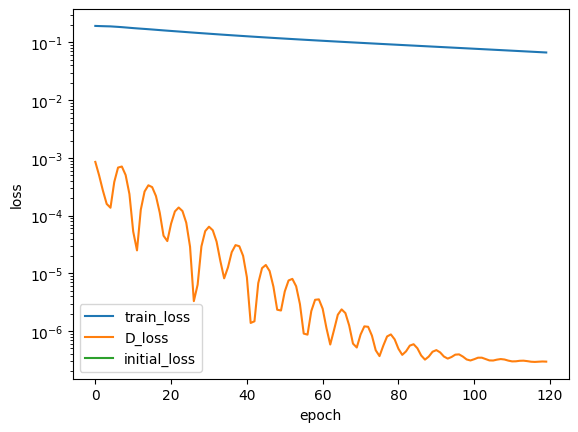

In [8]:
trainer_metrics = trainer.callbacks[0].metrics
for metric, loss in trainer_metrics.items():
    plt.plot(range(len(loss)), loss, label=metric)
# plotting
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")
plt.legend()

print(f"Entrenamiento duró {end - start:.3f} segundos")

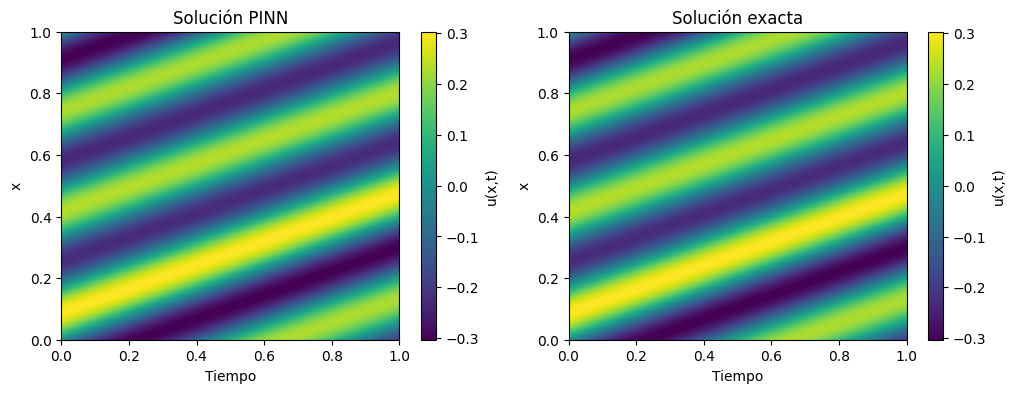

In [9]:
x = problem.spatial_domain.sample(300, "grid")
t = problem.temporal_domain.sample(300, "grid")
points = x.append(t, mode="cross")  # 100 × 100 = 10 000 puntos

with torch.no_grad():
    u_pred = solver.model(points)
U_pred = u_pred.detach().cpu().numpy().reshape(300, 300)
U_true = problem.solution(points).detach().cpu().numpy().reshape(300, 300)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Solución PINN")
plt.imshow(U_pred.T, origin="lower", extent=[0, 1, 0, 1], aspect="auto")
plt.colorbar(label="u(x,t)")
plt.xlabel("Tiempo")
plt.ylabel("x")

plt.subplot(1, 2, 2)
plt.title("Solución exacta")
plt.imshow(U_true.T, origin="lower", extent=[0, 1, 0, 1], aspect="auto")
plt.colorbar(label="u(x,t)")
plt.xlabel("Tiempo")
plt.ylabel("x")
plt.show()

Número de Courant (CFL) = 0.38
Error df:0.00071716, Error PINN:0.00000006


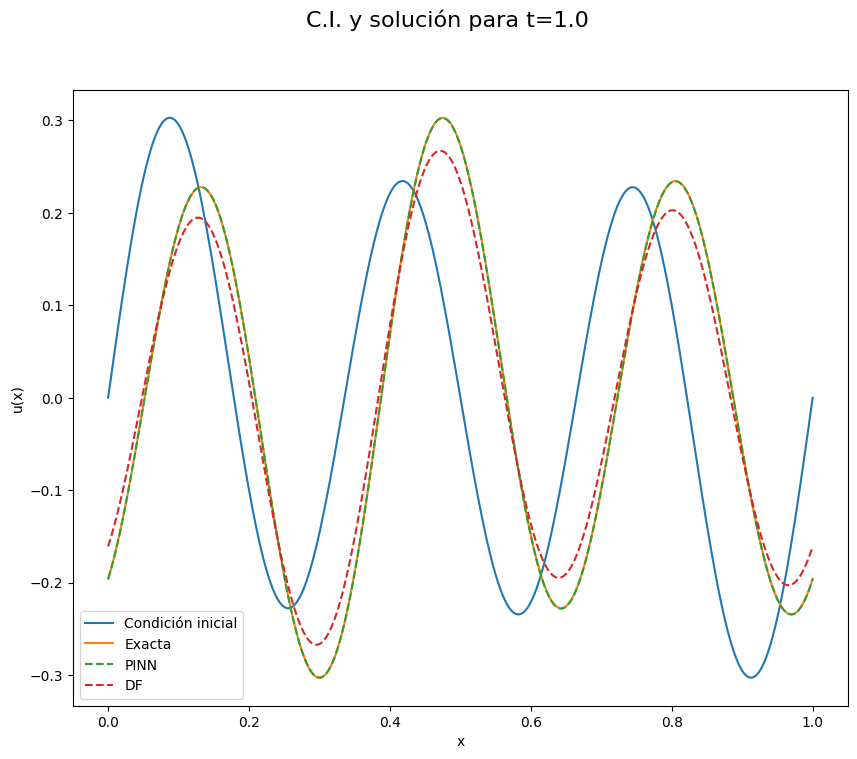

In [10]:
spatial_samples = problem.spatial_domain.sample(300, "grid")
time_0 = LabelTensor(torch.tensor([[0]]), "t")
time_1 = LabelTensor(torch.tensor([[1]]), "t")

points_0 = spatial_samples.append(time_0, mode="cross")
points_1 = spatial_samples.append(time_1, mode="cross")

with torch.no_grad():
    u_pred = solver.model(points_1)
u_pred = u_pred.detach().cpu().numpy().flatten()

u_true_0 = problem.solution(points_0).detach().cpu().numpy().flatten()
u_true_1 = problem.solution(points_1).detach().cpu().numpy().flatten()

x_fdm, u_fdm = FDM(problem.amplitudes, problem.c, dt=0.0033)

error_fdm = u_true_1 - u_fdm
error_pinn = u_true_1 - u_pred
mse_fdm = np.mean(error_fdm**2)
mse_pinn = np.mean(error_pinn**2)
print(f"Error df:{mse_fdm:.8f}, Error PINN:{mse_pinn:.8f}")

plt.figure(figsize=(10, 8))
plt.suptitle("C.I. y solución para t=1.0", fontsize=16)
plt.plot(x, u_true_0, label="Condición inicial")
plt.plot(x, u_true_1, label="Exacta")
plt.plot(x, u_pred, "--", label="PINN")
plt.plot(x_fdm, u_fdm, "--", label="DF")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.show()

In [11]:
print(problem.amplitudes[0].tolist(), problem.amplitudes[1].tolist(), problem.amplitudes[2].tolist(),)
print(problem.c[0].tolist())

[0.027871843427419662] [0.03908291831612587] [0.2543724477291107]
0.3873591721057892


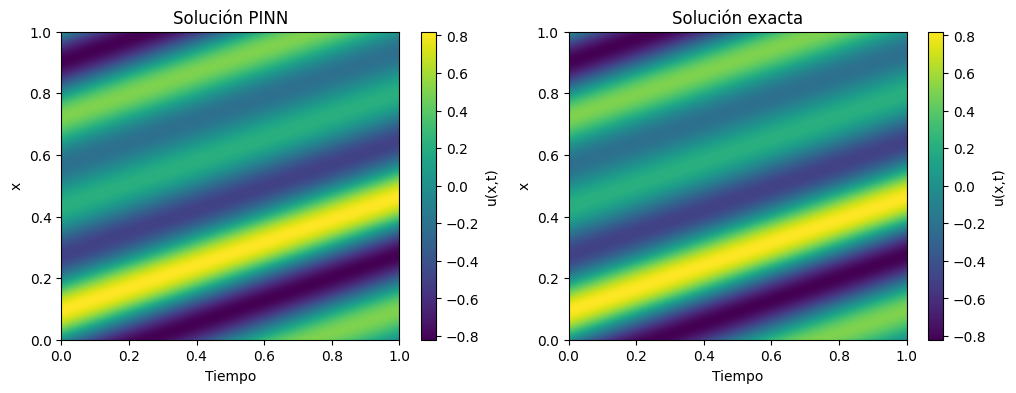

In [12]:
problem_test = Advection()  # Nueva instancia → nuevos valores de amplitudes/fases

# 1) copiar amplitudes y phases del problema nuevo al modelo
solver.model.amplitudes = problem_test.amplitudes
solver.model.c = problem_test.c

# 2) evaluar sobre nuevos puntos
x_test = problem_test.spatial_domain.sample(300, "grid")
t_test = problem_test.temporal_domain.sample(300, "grid")
points_test = x_test.append(t_test, mode="cross")

with torch.no_grad():
    u_pred = solver.model(points_test)

U_pred = u_pred.detach().cpu().numpy().reshape(300, 300)
U_true = problem_test.solution(points_test).detach().cpu().numpy().reshape(300, 300)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Solución PINN")
plt.imshow(U_pred.T, origin="lower", extent=[0, 1, 0, 1], aspect="auto")
plt.colorbar(label="u(x,t)")
plt.xlabel("Tiempo")
plt.ylabel("x")

plt.subplot(1, 2, 2)
plt.title("Solución exacta")
plt.imshow(U_true.T, origin="lower", extent=[0, 1, 0, 1], aspect="auto")
plt.colorbar(label="u(x,t)")
plt.xlabel("Tiempo")
plt.ylabel("x")
plt.show()

In [13]:
print(problem_test.amplitudes[0].tolist(), problem_test.amplitudes[1].tolist(), problem_test.amplitudes[2].tolist(),)
print(problem_test.c[0].tolist())

[0.03891867399215698] [0.3493445813655853] [0.4845098853111267]
0.37045979499816895


In [14]:
time_0 = LabelTensor(torch.tensor([[0]]), "t")
time_015 = LabelTensor(torch.tensor([[0.15]]), "t")
time_05 = LabelTensor(torch.tensor([[0.5]]), "t")
time_1 = LabelTensor(torch.tensor([[1]]), "t")

points_test_0 = x_test.append(time_0, mode="cross")
points_test_015 = x_test.append(time_015, mode="cross")
points_test_05 = x_test.append(time_05, mode="cross")
points_test_1 = x_test.append(time_1, mode="cross")

with torch.no_grad():
    U_pred_0 = solver.model(points_test_0)
    U_pred_015 = solver.model(points_test_015)
    U_pred_05 = solver.model(points_test_05)
    U_pred_1 = solver.model(points_test_1)
U_pred_0 = U_pred_0.detach().cpu().numpy().flatten()
U_pred_015 = U_pred_015.detach().cpu().numpy().flatten()
U_pred_05 = U_pred_05.detach().cpu().numpy().flatten()
U_pred_1 = U_pred_1.detach().cpu().numpy().flatten()

U_true_0 = problem_test.solution(points_test_0).detach().cpu().numpy().flatten()
U_true_015 = problem_test.solution(points_test_015).detach().cpu().numpy().flatten()
U_true_05 = problem_test.solution(points_test_05).detach().cpu().numpy().flatten()
U_true_1 = problem_test.solution(points_test_1).detach().cpu().numpy().flatten()

Número de Courant (CFL) = 0.06
Error df:0.00012270, Error PINN:0.00000001


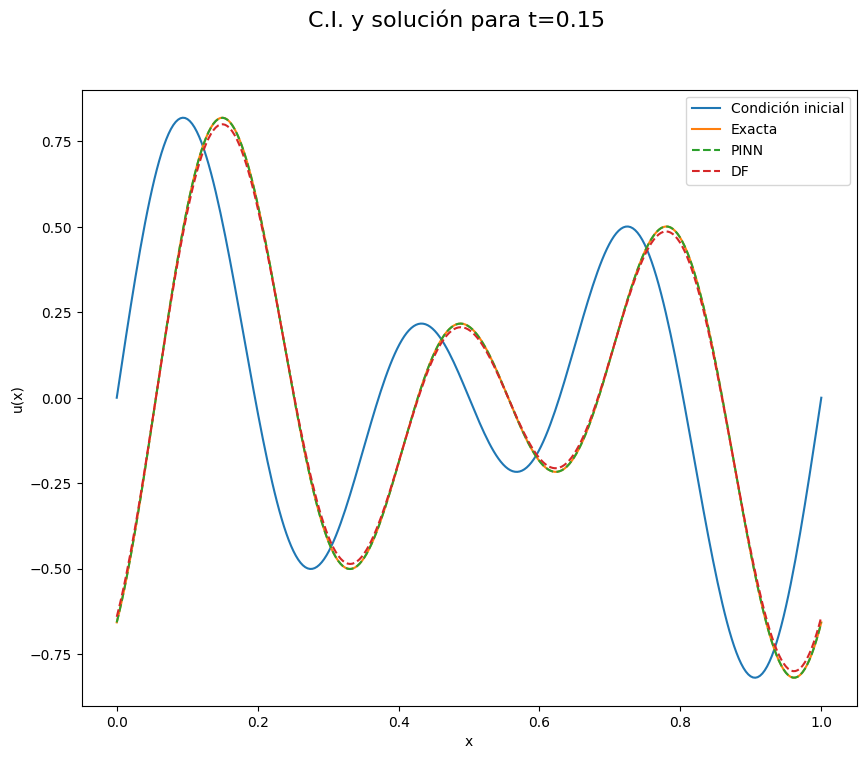

In [15]:
# error en t=0.15
x_fdm_015, u_fdm_015 = FDM(problem_test.amplitudes, problem_test.c, dt=0.0005)
error_fdm_015 = U_true_015 - u_fdm_015
error_pinn_015 = U_true_015 - U_pred_015
mse_fdm_015 = np.mean(error_fdm_015**2)
mse_pinn_015 = np.mean(error_pinn_015**2)
print(f"Error df:{mse_fdm_015:.8f}, Error PINN:{mse_pinn_015:.8f}")

plt.figure(figsize=(10, 8))
plt.suptitle("C.I. y solución para t=0.15", fontsize=16)
plt.plot(x_test, U_true_0, label="Condición inicial")
plt.plot(x_test, U_true_015, label="Exacta")
plt.plot(x_test, U_pred_015, "--", label="PINN")
plt.plot(x_fdm_015, u_fdm_015, "--", label="DF")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.show()

Número de Courant (CFL) = 0.18
Error df:0.00096228, Error PINN:0.00000004


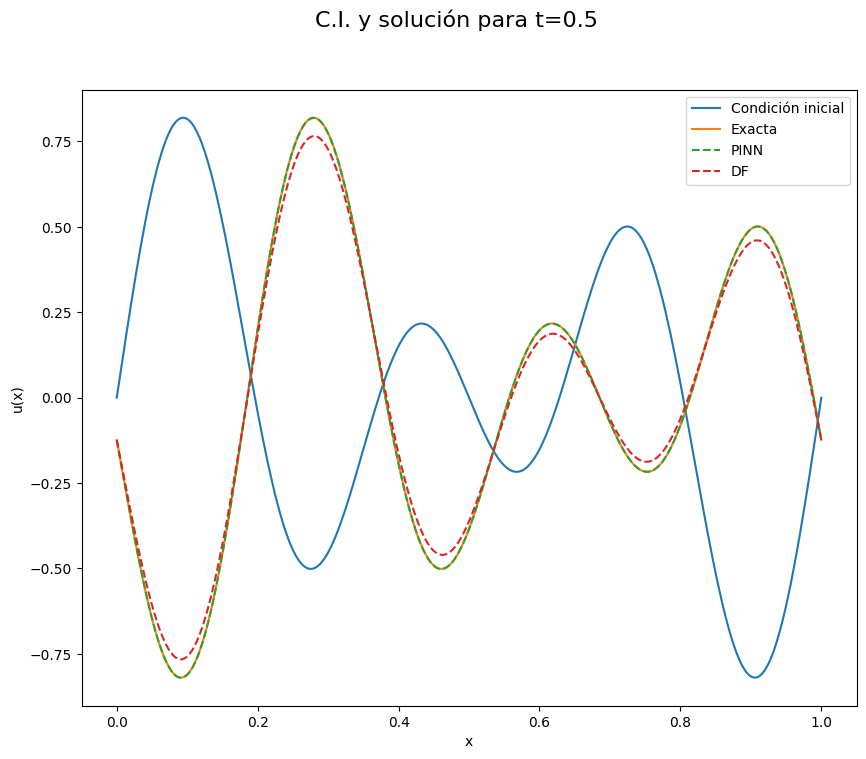

In [16]:
# error en t=0.5
x_fdm_05, u_fdm_05 = FDM(problem_test.amplitudes, problem_test.c, dt=0.00167)
error_fdm_05 = U_true_05 - u_fdm_05
error_pinn_05 = U_true_05 - U_pred_05
mse_fdm_05 = np.mean(error_fdm_05**2)
mse_pinn_05 = np.mean(error_pinn_05**2)
print(f"Error df:{mse_fdm_05:.8f}, Error PINN:{mse_pinn_05:.8f}")

plt.figure(figsize=(10, 8))
plt.suptitle("C.I. y solución para t=0.5", fontsize=16)
plt.plot(x_test, U_true_0, label="Condición inicial")
plt.plot(x_test, U_true_05, label="Exacta")
plt.plot(x_test, U_pred_05, "--", label="PINN")
plt.plot(x_fdm_05, u_fdm_05, "--", label="DF")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.show()

Número de Courant (CFL) = 0.37
Error df:0.00280625, Error PINN:0.00000006


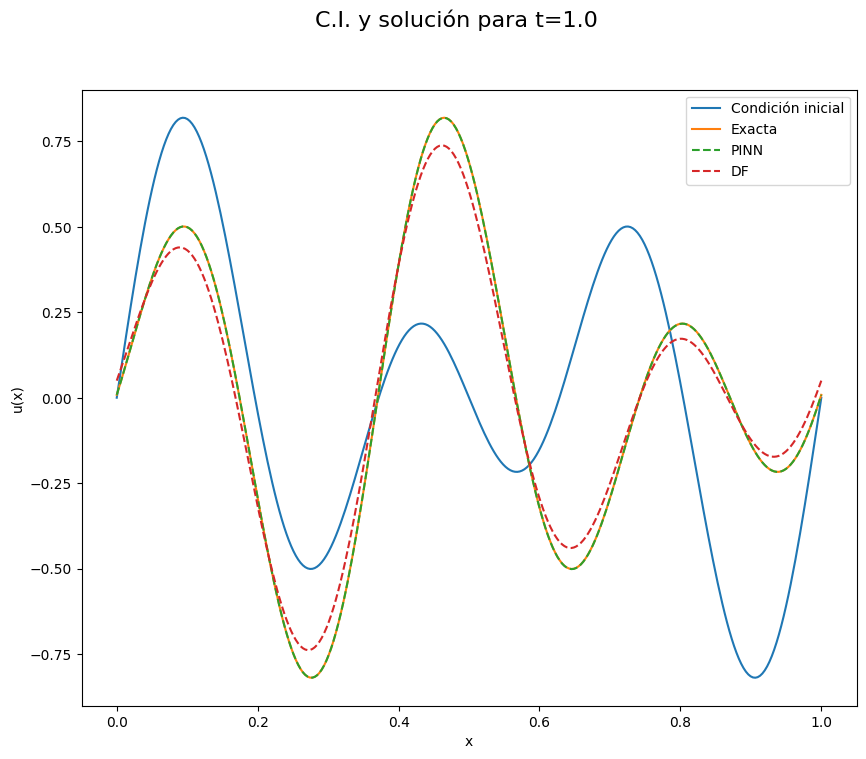

In [17]:
# error en t=1
x_fdm_1, u_fdm_1 = FDM(problem_test.amplitudes, problem_test.c, dt=0.0033)
error_fdm_1 = U_true_1 - u_fdm_1
error_pinn_1 = U_true_1 - U_pred_1
mse_fdm_1 = np.mean(error_fdm_1**2)
mse_pinn_1 = np.mean(error_pinn_1**2)
print(f"Error df:{mse_fdm_1:.8f}, Error PINN:{mse_pinn_1:.8f}")

plt.figure(figsize=(10, 8))
plt.suptitle("C.I. y solución para t=1.0", fontsize=16)
plt.plot(x_test, U_true_0, label="Condición inicial")
plt.plot(x_test, U_true_1, label="Exacta")
plt.plot(x_test, U_pred_1, "--", label="PINN")
plt.plot(x_fdm_1, u_fdm_1, "--", label="DF")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.show()